In [1]:
# pip install mlflow

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import joblib
import mlflow
import mlflow.sklearn

In [3]:
# Set up MLflow locally
import os
mlflow.set_tracking_uri(f"file:///{os.getcwd()}/mlruns")  # uses current working dir
mlflow.set_experiment("Churn_Prediction_AdaptiveML")

<Experiment: artifact_location='file:///C:\\Users\\ajhna/mlruns/761644685219724127', creation_time=1744238007982, experiment_id='761644685219724127', last_update_time=1744238007982, lifecycle_stage='active', name='Churn_Prediction_AdaptiveML', tags={}>

In [4]:
# Load the dataset
df = pd.read_csv('data/Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Drop customerID and convert TotalCharges
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

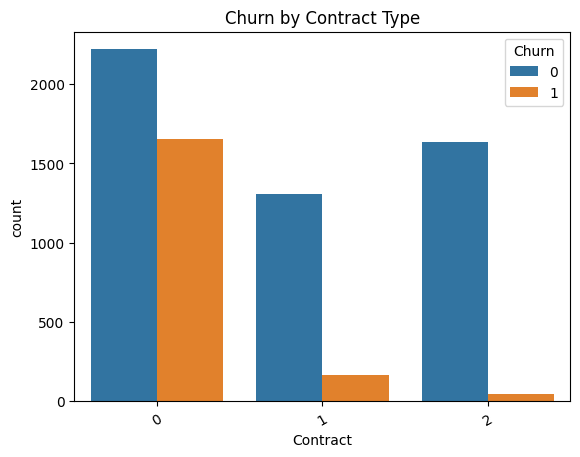

In [7]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn by Contract Type")
plt.xticks(rotation=30)
plt.show()

In [8]:
#Train-test split

X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Random Forest with MLflow Logging
with mlflow.start_run(run_name="baseline_rf_model"):

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    acc = (y_pred_rf == y_test).mean()
    auc = roc_auc_score(y_test, y_pred_rf)

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", auc)

    mlflow.sklearn.log_model(rf, "model")

    print("Random Forest:\n", classification_report(y_test, y_pred_rf))

2025/04/09 15:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [10]:
# Save the model locally
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/churn_model_v1.pkl")

['models/churn_model_v1.pkl']